In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import torch
import torchvision.transforms as T
from sklearn.model_selection import train_test_split
from tqdm.autonotebook import tqdm, trange
from torch.nn.functional import softmax
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision.datasets import ImageFolder


from predictors.alexnet import Alexnet
from predictors.half_alexnet import HalfAlexnet

from datasets import CIFAR10

%matplotlib inline

In [3]:
LR = 0.001
EPOCHS = 200
BATCH_SIZE = 32
CONFIDENCE_TH = 0.8

DATASET_PATH = '.'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
# Teacher
teacher_model = Alexnet(name=None, n_outputs=10)

ckpt_path = 'checkpoints/teacher_alexnet_for_cifar10_state_dict'
teacher_model.load_state_dict(torch.load(ckpt_path, map_location=device))
teacher_model.eval()
teacher_model.to(device)

Alexnet(
  (conv1): Conv2d(3, 48, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu): ReLU()
  (lrn): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
  (pad): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batch_norm1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(48, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batch_norm2): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm3): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm4): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(192, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm5): BatchNorm2d(128, eps=0.001, m

In [5]:
# Define dataset
label_mapper = {
    'airplane': 0,
    'automobile': 1,
    'bird': 2,
    'cat': 3,
    'deer': 4,
    'dog': 5,
    'frog': 6,
    'horse': 7,
    'ship': 8,
    'truck': 9
}
label_mapper_inv = {v:k for k,v in label_mapper.items()}

# Get images paths and labels
images = []
labels = []
folders_path = os.path.join(DATASET_PATH,'images_generated')
for folder in os.listdir(folders_path):
    if 'imagenet' in folder:
      continue
    class_path = os.path.join(folders_path,folder)
    images_names = os.listdir(class_path)
    
    for image_name in images_names:
        images.append(os.path.join(class_path,image_name))
        labels.append(label_mapper[folder])

In [6]:
# Define dataset class
class ProxyDataset(Dataset):
    def __init__(self, images, labels, transform=None, return_path=False, soft_label=None):
        self.images = images
        self.labels = labels
        self.soft_label = soft_label
        
        self.transform = transform
        
        self.return_path = return_path

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = read_image(self.images[idx])
        image = image / 255.0
        
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
            
        if self.return_path:
            return image, label, self.images[idx]
        
        return image, label, self.soft_label[idx]
    
# Filter out images with low confidence score
proxy_transforms = T.Compose([
    T.Resize((32,32)),
    T.Normalize((0.5,), (0.5,))
])

proxy_dataset = ProxyDataset(images, labels, proxy_transforms, True)
proxy_dataloader  = DataLoader(proxy_dataset,  batch_size=BATCH_SIZE)

filtered_images = []
filtered_labels = []
filtered_soft_labels = []

with torch.no_grad():
    for img,label,path in tqdm(proxy_dataloader):
        img = img.to(device=device)
        label = label.to(device=device)

        logits = teacher_model(img)
        pred = softmax(logits, dim=1)
        
        confidence,y_hat = torch.max(pred, dim=1)

        filtered_images.extend(list(path))
        filtered_labels.extend(y_hat.tolist())
        filtered_soft_labels.extend(pred)
        
# Display results of filtering
print(f'A total of {len(filtered_images)} remained out of {len(proxy_dataset)}')
print()
counter_per_class = {v:0 for k,v in label_mapper.items()}
for label in filtered_labels:
    counter_per_class[label] += 1
for clasa in counter_per_class:
    print(f'Class {clasa}({label_mapper_inv[clasa]}) has {counter_per_class[clasa]} entries')

  0%|          | 0/1600 [00:00<?, ?it/s]

A total of 51200 remained out of 51200

Class 0(airplane) has 6384 entries
Class 1(automobile) has 5145 entries
Class 2(bird) has 4795 entries
Class 3(cat) has 5331 entries
Class 4(deer) has 5571 entries
Class 5(dog) has 4286 entries
Class 6(frog) has 4553 entries
Class 7(horse) has 5025 entries
Class 8(ship) has 5178 entries
Class 9(truck) has 4932 entries


In [148]:
# Define the student model
student_model = HalfAlexnet(name=None, n_outputs=10)

path_to_save = 'pretrained_student.pt'
student_model.load_state_dict(torch.load(path_to_save))
student_model.to(device)

# Define optimizer
optimizer = torch.optim.Adam(student_model.parameters(), lr=LR)

# Define loss function
criterion = torch.nn.CrossEntropyLoss(reduction='mean')

In [149]:
""" Old block: used with percengtages
PERCENTAGE_TO_USE = 0.8
print(f'Examples used: {len(filtered_images)*PERCENTAGE_TO_USE}')

filtered_images_subset, _, filtered_labels_subset, _, filtered_soft_labels_subset, _ = \
    train_test_split(filtered_images, filtered_labels, filtered_soft_labels, train_size=PERCENTAGE_TO_USE, stratify=filtered_labels)

train_images, validation_images, train_labels, validation_labels, train_soft_labels, validation_soft_labels = \
      train_test_split(filtered_images_subset, filtered_labels_subset, filtered_soft_labels_subset, train_size=0.8, stratify=filtered_labels)
valid_images, test_images, valid_labels, test_labels, valid_soft_labels, test_soft_labels = \
    train_test_split(validation_images, validation_labels, validation_soft_labels, test_size=0.5, stratify=validation_labels)
"""

try:
  # raise
  # Do a stratified split of the data
  NO_IMGS_TO_USE = 32768
  
  filtered_images_subset, filtered_images_unused, filtered_labels_subset, filtered_labels_unused, filtered_soft_labels_subset, filtered_soft_labels_unused = \
      train_test_split(filtered_images, filtered_labels, filtered_soft_labels, train_size=NO_IMGS_TO_USE, stratify=filtered_labels)  

  train_images, validation_images, train_labels, validation_labels, train_soft_labels, validation_soft_labels = \
      train_test_split(filtered_images_subset, filtered_labels_subset, filtered_soft_labels_subset, train_size=0.8, stratify=filtered_labels_subset)
  valid_images, test_images, valid_labels, test_labels, valid_soft_labels, test_soft_labels = \
      train_test_split(validation_images, validation_labels, validation_soft_labels, test_size=0.5, stratify=validation_labels)
except:
  # For small datasets 
  print('Small dataset')
  NO_IMGS_TO_USE = 60
  NO_TRAIN_IMGS = 40

  """ DEV - train_test_split fails, need to manually introduce 1 sample
  for i in range(len(filtered_labels)-1,-1,-1):
    if filtered_labels[i] == 5:
      img_dev = filtered_images[i]
      soft_label_dev = filtered_soft_labels[i]
      break
  """

  filtered_images_subset, filtered_images_unused, filtered_labels_subset, filtered_labels_unused, filtered_soft_labels_subset, filtered_soft_labels_unused = \
    train_test_split(filtered_images, filtered_labels, filtered_soft_labels, train_size=NO_IMGS_TO_USE, stratify=filtered_labels)  
  train_images, validation_images, train_labels, validation_labels, train_soft_labels, validation_soft_labels = \
    train_test_split(filtered_images_subset, filtered_labels_subset, filtered_soft_labels_subset, train_size=NO_TRAIN_IMGS, stratify=filtered_labels_subset)
  
  """ DEV - interchange an image
  for i in range(len(validation_images)):
    if validation_labels[i] == 0:
      validation_images[i] = img_dev
      validation_labels[i] = 5
      validation_soft_labels[i] = soft_label_dev
      break
  """

  valid_images, test_images, valid_labels, test_labels, valid_soft_labels, test_soft_labels = \
      train_test_split(validation_images, validation_labels, validation_soft_labels, test_size=0.5, stratify=validation_labels)

In [150]:
# Define the transformations
train_transforms = T.Compose([
    T.Resize((32,32)),
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(p=0.5),
    T.Normalize((0.5,), (0.5,))
])
valid_transforms = T.Compose([
    T.Resize((32,32)),
    T.Normalize((0.5,), (0.5,))
])

# Define the datasets
proxy_train_dataset = ProxyDataset(train_images, train_labels, train_transforms, False, train_soft_labels)
proxy_valid_dataset = ProxyDataset(valid_images, valid_labels, valid_transforms, False, valid_soft_labels)
proxy_test_dataset  = ProxyDataset(test_images,  test_labels,  valid_transforms, False, test_soft_labels)

# Define the dataloaders
train_dataloader = DataLoader(proxy_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(proxy_valid_dataset, batch_size=BATCH_SIZE)
test_dataloader  = DataLoader(proxy_test_dataset,  batch_size=BATCH_SIZE)

In [151]:
# Define true dataset
true_dataset = CIFAR10(input_size = 32)

validate_on_trueds = True
if validate_on_trueds:
    true_valid_ds = true_dataset.test_dataloader()

Files already downloaded and verified
Files already downloaded and verified


In [152]:
# Class for early stopping
class EarlyStopping():
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, validation_loss):
        if self.best_score is None:
          self.best_score = validation_loss
        elif validation_loss - self.best_score < self.min_delta:
          self.best_score = validation_loss
        else:
          self.counter +=1
          if self.counter >= self.tolerance:  
              self.early_stop = True

In [153]:
early_stopping = EarlyStopping(tolerance=20, min_delta=0.001)
# early_stopping = EarlyStopping(tolerance=5, min_delta=0.001)

# Training the student
for epoch in range(EPOCHS):
    # Define progress bar
    loop = tqdm(enumerate(train_dataloader), total=len(train_dataloader))
    
    # Training loop
    student_model.train()
    training_loss_epoch = []
    for batch_idx, (x,y,soft_y) in loop:
        optimizer.zero_grad()
        
        x = x.to(device=device)
        y = y.to(device=device)
        soft_y = soft_y.to(device=device)
        
        # Forward pass
        logits = student_model(x)
        # Backward pass
        loss = criterion(input=logits, target=soft_y)
        training_loss_epoch.append(loss.item())
        # Prob trb inlocuit criterionul, sa adaugi soft-labels
        loss.backward()
        
        # Optimize
        optimizer.step()
        
        # Update progress bar
        loop.set_description(f'Epoch {epoch+1}/{EPOCHS}')
        loop.set_postfix(training_loss=loss.item())
    
    # Validation loop on proxy validation dataset
    student_model.eval()
    validation_loss_epoch = []  
    acc = 0
    with torch.no_grad():
        for x,y,_ in valid_dataloader:
            x = x.to(device=device)
            y = y.to(device=device)
        
            logits = student_model(x)
            pred = softmax(logits, dim=1)
            
            confidence,y_hat = torch.max(pred, dim=1)
            
            loss = criterion(input=logits, target=y)
            validation_loss_epoch.append(loss.item())
            
            acc += torch.sum(y_hat==y).item()
        
    loop.write(f'validation_loss on proxy = {sum(validation_loss_epoch)/len(validation_loss_epoch):.4f}')
    loop.write(f'validation_accuracy on proxy = {100*acc/len(proxy_valid_dataset):.2f}%')

    if validate_on_trueds:
        # Validation loop on proxy validation dataset
        student_model.eval()
        with torch.no_grad():
            val_loss = []
            acc = 0
            for x,y in true_valid_ds:
                x = x.to(device=device)
                y = y.to(device=device)
            
                logits = student_model(x)
                pred = softmax(logits, dim=1)
                
                confidence,y_hat = torch.max(pred, dim=1)
                
                loss = criterion(input=logits, target=y)
                val_loss.append(loss.item())
                
                acc += torch.sum(y_hat==y).item()
            
        loop.write(f'validation_loss on true ds = {sum(val_loss)/len(val_loss):.4f}')
        loop.write(f'validation_accuracy on true ds = {100*acc/len(true_dataset.test_dataset):.2f}%')

    early_stopping(sum(validation_loss_epoch)/len(validation_loss_epoch))
    if early_stopping.early_stop:
      print(f"We are at epoch {epoch}")
      break

  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.5686
validation_accuracy on proxy = 82.24%
validation_loss on true ds = 1.3589
validation_accuracy on true ds = 52.48%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.5197
validation_accuracy on proxy = 84.77%
validation_loss on true ds = 1.2279
validation_accuracy on true ds = 57.36%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.5095
validation_accuracy on proxy = 84.83%
validation_loss on true ds = 1.2049
validation_accuracy on true ds = 58.49%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.5022
validation_accuracy on proxy = 84.71%
validation_loss on true ds = 1.1489
validation_accuracy on true ds = 59.40%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4856
validation_accuracy on proxy = 85.35%
validation_loss on true ds = 1.1393
validation_accuracy on true ds = 60.56%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4890
validation_accuracy on proxy = 85.41%
validation_loss on true ds = 1.1476
validation_accuracy on true ds = 60.80%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4641
validation_accuracy on proxy = 86.02%
validation_loss on true ds = 1.0974
validation_accuracy on true ds = 62.15%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4588
validation_accuracy on proxy = 86.12%
validation_loss on true ds = 1.0581
validation_accuracy on true ds = 62.61%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4640
validation_accuracy on proxy = 85.99%
validation_loss on true ds = 1.0906
validation_accuracy on true ds = 62.16%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4668
validation_accuracy on proxy = 85.78%
validation_loss on true ds = 1.1027
validation_accuracy on true ds = 62.51%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4605
validation_accuracy on proxy = 86.30%
validation_loss on true ds = 1.0313
validation_accuracy on true ds = 64.02%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4592
validation_accuracy on proxy = 85.75%
validation_loss on true ds = 1.0242
validation_accuracy on true ds = 65.30%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4676
validation_accuracy on proxy = 85.29%
validation_loss on true ds = 1.0058
validation_accuracy on true ds = 65.16%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4429
validation_accuracy on proxy = 86.42%
validation_loss on true ds = 1.0074
validation_accuracy on true ds = 64.74%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4438
validation_accuracy on proxy = 86.18%
validation_loss on true ds = 0.9642
validation_accuracy on true ds = 67.15%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4410
validation_accuracy on proxy = 86.30%
validation_loss on true ds = 0.9915
validation_accuracy on true ds = 66.30%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4360
validation_accuracy on proxy = 86.97%
validation_loss on true ds = 0.9690
validation_accuracy on true ds = 66.72%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4466
validation_accuracy on proxy = 85.99%
validation_loss on true ds = 0.9659
validation_accuracy on true ds = 66.96%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4394
validation_accuracy on proxy = 86.12%
validation_loss on true ds = 1.0119
validation_accuracy on true ds = 64.94%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4592
validation_accuracy on proxy = 85.78%
validation_loss on true ds = 1.0412
validation_accuracy on true ds = 64.28%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4423
validation_accuracy on proxy = 86.94%
validation_loss on true ds = 0.9501
validation_accuracy on true ds = 67.65%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4345
validation_accuracy on proxy = 86.42%
validation_loss on true ds = 0.9362
validation_accuracy on true ds = 67.78%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4360
validation_accuracy on proxy = 86.57%
validation_loss on true ds = 0.9546
validation_accuracy on true ds = 67.79%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4283
validation_accuracy on proxy = 87.03%
validation_loss on true ds = 0.9486
validation_accuracy on true ds = 67.26%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4380
validation_accuracy on proxy = 87.12%
validation_loss on true ds = 1.0037
validation_accuracy on true ds = 65.79%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4352
validation_accuracy on proxy = 87.09%
validation_loss on true ds = 0.9515
validation_accuracy on true ds = 67.41%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4344
validation_accuracy on proxy = 86.97%
validation_loss on true ds = 0.9449
validation_accuracy on true ds = 67.14%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4635
validation_accuracy on proxy = 85.99%
validation_loss on true ds = 0.9619
validation_accuracy on true ds = 67.68%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4374
validation_accuracy on proxy = 86.63%
validation_loss on true ds = 0.9451
validation_accuracy on true ds = 67.44%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4398
validation_accuracy on proxy = 86.63%
validation_loss on true ds = 0.9279
validation_accuracy on true ds = 68.58%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4381
validation_accuracy on proxy = 86.51%
validation_loss on true ds = 0.9002
validation_accuracy on true ds = 69.64%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4481
validation_accuracy on proxy = 86.76%
validation_loss on true ds = 0.9496
validation_accuracy on true ds = 68.60%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4418
validation_accuracy on proxy = 86.39%
validation_loss on true ds = 0.9319
validation_accuracy on true ds = 68.19%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4558
validation_accuracy on proxy = 85.66%
validation_loss on true ds = 1.0141
validation_accuracy on true ds = 66.39%
We are at epoch 33


In [154]:
# Testing on CIFAR10 ground truth
true_dataloader = true_dataset.test_dataloader()
acc_per_class = {k:[0,0,0] for k,v in label_mapper_inv.items()}

student_model.eval()
with torch.no_grad():
    test_loss = []
    acc = 0
    for x,y in true_dataloader:
        x = x.to(device=device)
        y = y.to(device=device)
    
        logits = student_model(x)
        pred = softmax(logits, dim=1)
        
        confidence,y_hat = torch.max(pred, dim=1)
        
        loss = criterion(input=logits, target=y)
        test_loss.append(loss.item())
        
        acc += torch.sum(y_hat==y)
        
        for i in range(len(y)):
            a = y[i].item()
            p = y_hat[i].item()
            
            
            acc_per_class[a][1] += 1
            acc_per_class[p][2] += 1
            if a == p:
                acc_per_class[a][0] += 1
        
    print('Student with true dataset:')
    print(f'test_loss = {sum(test_loss)/len(test_loss):.4f}')                  # 1.7439;  1.6199
    print(f'test_accuracy = {100*acc/len(true_dataset.test_dataset):.2f}%')    # 46.09%;  48.57%
    print()
    
for k,v in acc_per_class.items():
    print(f'Class {label_mapper_inv[k]}: pred={v[0]}, actual={v[1]} => acc={v[0]*100/v[1]:.2f}%, total_pred={v[2]}')

Student with true dataset:
test_loss = 1.0141
test_accuracy = 66.39%

Class airplane: pred=627, actual=1000 => acc=62.70%, total_pred=837
Class automobile: pred=733, actual=1000 => acc=73.30%, total_pred=831
Class bird: pred=545, actual=1000 => acc=54.50%, total_pred=885
Class cat: pred=698, actual=1000 => acc=69.80%, total_pred=1641
Class deer: pred=552, actual=1000 => acc=55.20%, total_pred=783
Class dog: pred=641, actual=1000 => acc=64.10%, total_pred=1274
Class frog: pred=675, actual=1000 => acc=67.50%, total_pred=922
Class horse: pred=615, actual=1000 => acc=61.50%, total_pred=790
Class ship: pred=702, actual=1000 => acc=70.20%, total_pred=852
Class truck: pred=851, actual=1000 => acc=85.10%, total_pred=1185


In [155]:
# Testing using labels predicted with teacher
true_dataloader = true_dataset.test_dataloader()
acc_per_class = {k:[0,0,0] for k,v in label_mapper_inv.items()}

student_model.eval()
teacher_model.eval()
with torch.no_grad():
    test_loss = []
    acc = 0
    for x,y in true_dataloader:
        x = x.to(device=device)
        # y = y.to(device=device)

        teacher_pred = softmax(teacher_model(x), dim=1)
        _, y = torch.max(teacher_pred, dim=1)
    
        logits = student_model(x)
        pred = softmax(logits, dim=1)
        
        confidence,y_hat = torch.max(pred, dim=1)
        
        loss = criterion(input=logits, target=y)
        test_loss.append(loss.item())
        
        acc += torch.sum(y_hat==y)
        
        for i in range(len(y)):
            a = y[i].item()
            p = y_hat[i].item()
            
            
            acc_per_class[a][1] += 1
            acc_per_class[p][2] += 1
            if a == p:
                acc_per_class[a][0] += 1
        
    print('Student with true dataset:')
    print(f'test_loss = {sum(test_loss)/len(test_loss):.4f}')                  # 1.7439;  1.6199
    print(f'test_accuracy = {100*acc/len(true_dataset.test_dataset):.2f}%')    # 46.09%;  48.57%
    print()
    
for k,v in acc_per_class.items():
    print(f'Class {label_mapper_inv[k]}: pred={v[0]}, actual={v[1]} => acc={v[0]*100/v[1]:.2f}%, total_pred={v[2]}')

Student with true dataset:
test_loss = 0.9777
test_accuracy = 66.78%

Class airplane: pred=645, actual=1038 => acc=62.14%, total_pred=837
Class automobile: pred=733, actual=1002 => acc=73.15%, total_pred=831
Class bird: pred=543, actual=965 => acc=56.27%, total_pred=885
Class cat: pred=670, actual=938 => acc=71.43%, total_pred=1641
Class deer: pred=583, actual=1108 => acc=52.62%, total_pred=783
Class dog: pred=633, actual=913 => acc=69.33%, total_pred=1274
Class frog: pred=680, actual=996 => acc=68.27%, total_pred=922
Class horse: pred=631, actual=1063 => acc=59.36%, total_pred=790
Class ship: pred=688, actual=939 => acc=73.27%, total_pred=852
Class truck: pred=872, actual=1038 => acc=84.01%, total_pred=1185


In [156]:
# Redefine training dataset and dataloader with no augmentation
proxy_train_dataset = ProxyDataset(train_images, train_labels, valid_transforms, False, train_soft_labels)
train_dataloader = DataLoader(proxy_train_dataset, batch_size=BATCH_SIZE, shuffle=True)


student_model.return_feature_domain = True

db_path = 'images_db'
images_path = os.path.join(db_path,'images')
labels_path = os.path.join(db_path,'labels')

images_db = []
labels_db = []

if not os.path.exists('images_db'):
  os.makedirs(db_path)
  os.makedirs(images_path)
  os.makedirs(labels_path)

  for i in range(10):
    os.makedirs(os.path.join(images_path,f'class{i}'))
    os.makedirs(os.path.join(labels_path,f'class{i}'))

# Create the database
student_model.eval()
with torch.no_grad():
  for dataloader in [train_dataloader, valid_dataloader, test_dataloader]:
    for x,y,soft_y in dataloader:
      x = x.to(device=device)

      _,latent_fm = student_model(x)

      for i in range(latent_fm.shape[0]):
        label = y[i].item()
        path_image = f'{images_path}/class{label}'
        path_label = f'{labels_path}/class{label}'
        
        idx = len(os.listdir(path_image))

        # torch.save(latent_fm[i].cpu(), f'{path_image}/t{idx}.pt')
        # torch.save(soft_y[i].cpu(), f'{path_label}/t{idx}.pt')

        images_db.append(latent_fm[i])
        labels_db.append(soft_y[i])

In [157]:
class DBDataset(Dataset):
  def __init__(self, images_db, labels_db):
    self.images_db = images_db
    self.labels_db = labels_db

  def __len__(self):
    return len(self.images_db)

  def __getitem__(self, idx):
    image = self.images_db[idx]
    label = self.labels_db[idx]

    return image, label

db_dataset = DBDataset(images_db=images_db, labels_db=labels_db)
db_dataloader = DataLoader(db_dataset, batch_size=128)

In [158]:
proxy_unused_dataset  = ProxyDataset(filtered_images_unused,  filtered_labels_unused,  valid_transforms, False, filtered_soft_labels_unused)

In [159]:
estimations = []
ground_truth = []

with torch.no_grad():
  for i in trange(len(proxy_unused_dataset)):
    image, label, soft_label = proxy_unused_dataset[i]
    image = image.to(device=device)

    _,latent_fm = student_model(image.unsqueeze(dim=0))

    # Calculate distances
    distances = []
    for img_db, softl_db in db_dataloader:
      img_db = img_db.to(device=device)

      dist = (img_db - latent_fm).pow(2).sum(dim=(-1,-2,-3)).sqrt()

      distances.extend(dist.cpu().tolist())

    # Get indices of smallest distances
    distances = np.array(distances)
    k = 3
    smallest_indices = np.argpartition(distances, k)[:k]

    smallest_d, smallest_slabels = [], []
    for small_idx in smallest_indices:
      img_db, softl_db = db_dataset[small_idx]
      smallest_d.append(img_db.cpu().numpy())
      smallest_slabels.append(softl_db.cpu().numpy())

    smallest_d = np.array(smallest_d)
    smallest_slabels = np.array(smallest_slabels)

    estimated_soft_label = smallest_slabels.mean(0)

    estimations.append(estimated_soft_label.argmax())
    ground_truth.append(soft_label.argmax().cpu().item())
    # print(f'Estimated hard label: {estimations[-1]}')
    # print(f'Actual hard label: {ground_truth[-1]}')

    if i % 1000 == 0 and i != 0:
      # Display results
      correct = (np.array(estimations) == np.array(ground_truth)).sum()
      print(f'{correct} / {len(estimations)}')

correct = (np.array(estimations) == np.array(ground_truth)).sum()
print(f'Final score: {correct} / {len(estimations)}')

  0%|          | 0/18432 [00:00<?, ?it/s]

825 / 1001
1671 / 2001
2541 / 3001
3400 / 4001
4246 / 5001
5088 / 6001
5936 / 7001
6790 / 8001
7651 / 9001
8523 / 10001
9381 / 11001
10243 / 12001
11091 / 13001
11968 / 14001
12831 / 15001
13707 / 16001
14541 / 17001
15414 / 18001
Final score: 15783 / 18432


In [160]:
import matplotlib.pyplot as plt


def plot_db(X_embedded, labels_cpu):
  # scale and move the coordinates so they fit [0; 1] range
  def scale_to_01_range(x):
      # compute the distribution range
      value_range = (np.max(x) - np.min(x))
  
      # move the distribution so that it starts from zero
      # by extracting the minimal value from all its values
      starts_from_zero = x - np.min(x)
  
      # make the distribution fit [0; 1] by dividing by its range
      return starts_from_zero / value_range
  
  # extract x and y coordinates representing the positions of the images on T-SNE plot
  tx = X_embedded[:, 0]
  ty = X_embedded[:, 1]
  
  tx = scale_to_01_range(tx)
  ty = scale_to_01_range(ty)

  # initialize a matplotlib plot
  fig = plt.figure(figsize=(6, 6), dpi=144)
  ax = fig.add_subplot(111)
  
  # for every class, we'll add a scatter plot separately
  for label in range(10):
      # find the samples of the current class in the data
      indices = [i for i, l in enumerate(labels_cpu) if l == label]
  
      # extract the coordinates of the points of this class only
      current_tx = np.take(tx, indices)
      current_ty = np.take(ty, indices)
  
      # add a scatter plot with the corresponding color and label
      ax.scatter(current_tx, current_ty, label=label)
  
  # build a legend using the labels we set previously
  ax.legend(loc='best')
  
  # finally, show the plot
  plt.show()

/home/vhondru/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/vhondru/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


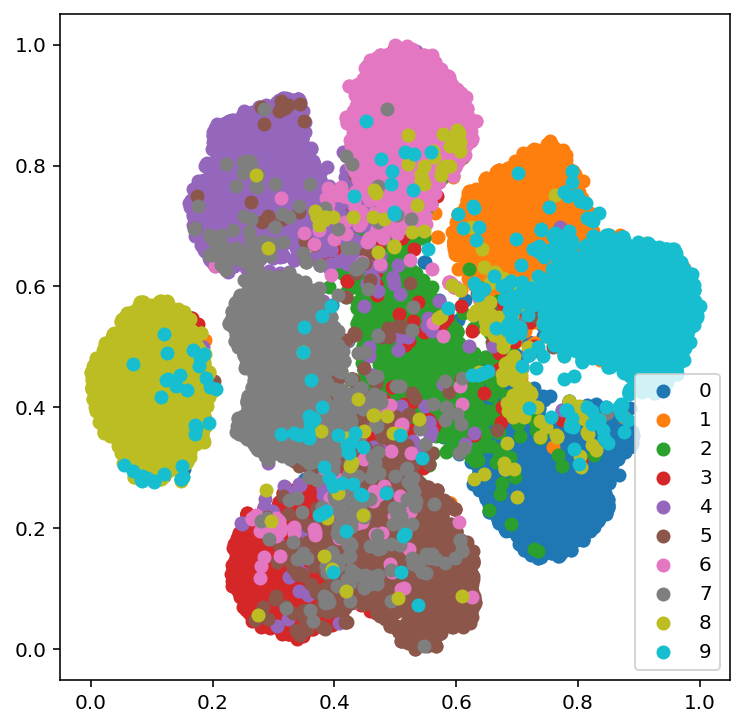

In [161]:
from sklearn.manifold import TSNE


tsne = TSNE()
images_cpu = [im.cpu().numpy().flatten() for im in images_db]
labels_cpu = [l.cpu().numpy().argmax() for l in labels_db]
X_embedded = tsne.fit_transform(np.array(images_cpu), np.array(labels_cpu))

plot_db(X_embedded, labels_cpu)

In [163]:
estimations = []
ground_truth = []

true_dataloader = torch.utils.data.DataLoader(
    true_dataset.test_dataset,
    batch_size = 1,
    num_workers = 2,
    drop_last = False
)
acc_per_class = {k:[0,0,0] for k,v in label_mapper_inv.items()}

student_model.eval()
with torch.no_grad():
  for image, soft_label in tqdm(true_dataloader):
    # image, label, soft_label = proxy_unused_dataset[i]
    image = image.to(device=device)
    soft_label = soft_label.to(device=device)

    _,latent_fm = student_model(image)
    # _,latent_fm = student_model(image.unsqueeze(dim=0))

    # Calculate distances
    distances = []
    for img_db, softl_db in db_dataloader:
      img_db = img_db.to(device=device)

      dist = (img_db - latent_fm).pow(2).sum(dim=(-1,-2,-3)).sqrt()

      distances.extend(dist.cpu().tolist())

    # Get indices of smallest distances
    distances = np.array(distances)
    k = 3
    smallest_indices = np.argpartition(distances, k)[:k]

    smallest_d, smallest_slabels = [], []
    for small_idx in smallest_indices:
      img_db, softl_db = db_dataset[small_idx]
      smallest_d.append(img_db.cpu().numpy())
      smallest_slabels.append(softl_db.cpu().numpy())

    smallest_d = np.array(smallest_d)
    smallest_slabels = np.array(smallest_slabels)

    estimated_soft_label = smallest_slabels.mean(0)

    estimations.append(estimated_soft_label.argmax())
    ground_truth.append(soft_label.argmax().cpu().item())
    # print(f'Estimated hard label: {estimations[-1]}')
    # print(f'Actual hard label: {ground_truth[-1]}')

    if i % 1000 == 0 and i != 0:
      # Display results
      correct = (np.array(estimations) == np.array(ground_truth)).sum()
      print(f'{correct} / {len(estimations)}')

correct = (np.array(estimations) == np.array(ground_truth)).sum()
print(f'Final score: {correct} / {len(estimations)}')

  0%|          | 0/10000 [00:00<?, ?it/s]

Final score: 993 / 10000


In [ ]:
# Testing on CIFAR10 ground truth


student_model.eval()
with torch.no_grad():
    test_loss = []
    acc = 0
    for x,y in true_dataloader:
        x = x.to(device=device)
        y = y.to(device=device)
    
        logits = student_model(x)
        pred = softmax(logits, dim=1)
        
        confidence,y_hat = torch.max(pred, dim=1)
        
        loss = criterion(input=logits, target=y)
        test_loss.append(loss.item())
        
        acc += torch.sum(y_hat==y)
        
        for i in range(len(y)):
            a = y[i].item()
            p = y_hat[i].item()
            
            
            acc_per_class[a][1] += 1
            acc_per_class[p][2] += 1
            if a == p:
                acc_per_class[a][0] += 1
        
    print('Student with true dataset:')
    print(f'test_loss = {sum(test_loss)/len(test_loss):.4f}')                  # 1.7439;  1.6199
    print(f'test_accuracy = {100*acc/len(true_dataset.test_dataset):.2f}%')    # 46.09%;  48.57%
    print()
    
for k,v in acc_per_class.items():
    print(f'Class {label_mapper_inv[k]}: pred={v[0]}, actual={v[1]} => acc={v[0]*100/v[1]:.2f}%, total_pred={v[2]}')